# Simulating Language, Lab 7, Hierarchical Bayesian Learning

This week we are working with a very simple hierarchical learning model, applying Bayes rule to learn a high-order proprty of the data. 

This model is built on the frequency learning model that we used in labs 3 and 4. Hopefully you remember from those labs that learners were exposed to data consisting of a sequence of productions of two variants, 0 and 1, and their task was to infer the probability of variant 1, which we sometimes refer to as $\theta$ and sometimes as `pW1` ("probability of word 1"). To do Bayesian inference we need a likelihood function and a prior. The likelihood from our frequency learning model was quite simple and gives you the probability of a particular sequence of 1s and 0s being generated given a particular value of `pW1` - when `pW1` is low then sequences with lots of 0s are more probable than sequences with lots of 1s, when `pW1` is high the reverse is true, and when `pW1` is around 0.5 you expect to see an even mix of 0s and 1s. For our prior we used a *beta distribution*, which is a family of probability distributions that can capture a uniform prior (representing an unbiased learner), a prior favouring regularity, or a prior favouring variability. We specify a single value for our beta distribution which by convention is called $\alpha$ (or `alpha`), which determines the shape of the distibution (NB `alpha` is not a probability, it's just a number we can manipulate to get different shaped priors); when `alpha` is less than 1 you have a prior favouring regularity (very low or very high values of `pW1` have the highest prior probability, and the prior assigns low prior probability to values of `pW1` around 0.5); when `alpha` is exactly 1 you have a flat prior (all values of `pW1` have equal prior probability); when `alpha` is greater than 1 you have a prior that favours variability (values of `pW1` around 0.5 have the highest prior probability, and extreme values of `pW1` have lower prior probability). 

In that frequency learning model, the `alpha` parameter therefore determines the learners' expectations about variability: we can build learners who expect low variability (by setting `alpha` to less than 1), or high variability (by setting `alpha` to greater than 1).  But the `alpha` parameter was set by *us*, the modeller. This week we are going to have learners learn the `alpha` value (rather than learning `pW1`); so they'll learn the higher-level property of whether they should expect variable or regular data.

## Old code

The first few chunks of code are borrowed from lab 4 - we'll need the usual stuff for dealing with log probabilities, and we'll also need some components of our lab 4 frequency-learning model. I am going to re-name some of those functions since we will now be dealing with likelihoods and priors for `pW1` *and* for `alpha`, so I want to name the functions so that it's clear whether they are e.g. the prior for `pW1` or for `alpha`.

### Libraries etc

First we'll load our library functions, and define the functions we need for doing some arithmetic with log probabilities. As usual, *it is not important that you understand exactly how these work* - they're just doing  book-keeping stuff to allow us to use log probabilities rather than probabilities.

In [1]:
import random
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

In [2]:
def log_subtract(x,y):
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                           #is equivalent to dividing in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    r=log(random.random()) #generate a random number between 0 and 1, then convert to log
    accumulator = normedlogs[0] 
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

### The hypothesis space, prior and likelihoods for pW1 

As in labs 3 and 4, the main part of the code starts by laying out our hypothesis space for `pW1`, our grid of possible values of `pW1` (which is the estimated probability of using variant 1). 

In [3]:
pW1_grid_granularity = 100
pW1_grid_increment = 1 / pW1_grid_granularity

# sets up the grid of possible probabilities to consider
possible_pW1 = []
for i in range(pW1_grid_granularity):
    possible_pW1.append(pW1_grid_increment / 2 + (pW1_grid_increment * i))

# sets up the grid of the corresponding log probabilities
possible_logpW1 = []
for pW1 in possible_pW1:
    possible_logpW1.append(log(pW1))

Next we need our prior over possible values of `pW1` - as per labs 3 and 4, this prior is a beta distribution, where the shape of that distribution is determined by the parameter `alpha`. In labs 3 and 4 this function was called `calculate_logprior(alpha)`, but here I am going to rename it `pW1_calculate_logprior(alpha)` to make it clear that this is the prior for values of `pW1`.

In [4]:
def pW1_calculate_logprior(alpha):
    logprior_pW1 = []
    for pW1 in possible_pW1:
        logprior_pW1.append(beta.logpdf(pW1, alpha, alpha)) 
    return normalize_logprobs(logprior_pW1)

We will also need a likelihood function, which tells us the likelihood of some data (a sequence of variants 0 and 1, e.g. `[0,1,1,0,1]`) given a particular (log) probability of `pW1`. This is the same as the `likelihood(data,logpW1)` function from lab 4, but again I have renamed it so it's clear that this is the likelihood for `pW1`.

In [5]:
def pW1_loglikelihood(data, logpW1):
    logpW0 = log_subtract(log(1), logpW1) #probability of w0 is 1-prob of w1
    logprobs = [logpW0, logpW1]
    loglikelihoods = []
    for d in data:
        loglikelihood_this_item = logprobs[d] #d will be either 0 or 1, 
                                              #so can use as index
        loglikelihoods.append(loglikelihood_this_item)
    return sum(loglikelihoods) #summing log probabilities = 
                               #multiply non-log probabilities

Finally we are going to want to get our model to produce some data (a sequence of 0s and 1s) given a particular value of (log) `pW1` - this was called `logproduce(logpW1, n_productions)` in lab 4, again I am renaming to make clear this is to do with `pW1`.

In [6]:
def pW1_logproduce(logpW1, n_productions):
    logpW0 = log_subtract(log(1), logpW1)
    logprobs = [logpW0, logpW1]
    data = []
    for p in range(n_productions):
        data.append(log_roulette_wheel(logprobs))
    return data



It might be worth checking at this point that you are happy with the behaviour of this part of the model - you could inspect the shape of the prior produced by `pW1_calculate_logprior(alpha)` for various values of `alpha`, check that `pW1_loglikelihood(data, logpW1)` generates sensible values, and that `pW1_logproduce(logpW1, n_productions)` behaves as expected. For instance, if you want to see that `pW1_logproduce` produces regular data when `pW1` is low or high, but variable data when `pW1` is around 0.5, you can do something like:

```python
print(pW1_logproduce(log(0.05), 20)) #try with pW1 = 0.1 (low)
print(pW1_logproduce(log(0.95), 20)) #try with pW1 = 0.9 (high)
print(pW1_logproduce(log(0.5), 20)) #try with pW1 = 0.5 (in the middle)
```

*OK, so let's take these in turn - I am just going to use code from lab4_answered since we already did all this stuff, but a refresher might not hurt!* 

*First, let's check the shape of the prior over values of `pW1` given different values for `alpha`.*

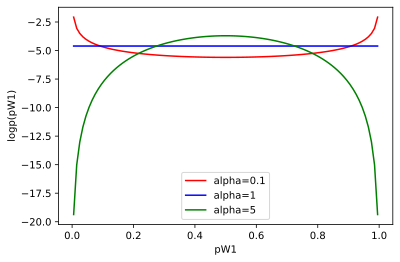

In [7]:
plt.plot(possible_pW1, pW1_calculate_logprior(0.1),'red',label="alpha=0.1")
plt.plot(possible_pW1, pW1_calculate_logprior(1),'blue',label="alpha=1")
plt.plot(possible_pW1, pW1_calculate_logprior(5),'green',label="alpha=5")
plt.xlabel("pW1")
plt.ylabel("logp(pW1)")
plt.legend()

*So those look a bit funny because the y axis is log probabilities rather than probabilities, but hopefully you can see the different shapes you get for `alpha` < 1 (very low or very high `pW1` has the highest prior), `alpha`=1 (completely flat) or `alpha`>1 (values of `pW1` around 0.5 favoured).*

*Next let's have a little look at the likelihood - at the top I said "when pW1 is low then sequences with lots of 0s are more probable than sequences with lots of 1s, when pW1 is high the reverse is true, and when pW1 is around 0.5 you expect to see an even mix of 0s and 1s.", so let's check I am not lying.*

"*when pW1 is low then sequences with lots of 0s are more probable than sequences with lots of 1s*"

In [8]:
print(exp(pW1_loglikelihood([0,0,0,0,0,0], log(0.1))))
print(exp(pW1_loglikelihood([1,1,1,1,1,1], log(0.1))))

0.5314409999999999
1.0000000000000023e-06


"*when pW1 is high the reverse is true*"

In [9]:
print(exp(pW1_loglikelihood([0,0,0,0,0,0], log(0.9))))
print(exp(pW1_loglikelihood([1,1,1,1,1,1], log(0.9))))

9.99999999999997e-07
0.531441


"*when pW1 is around 0.5 you expect to see an even mix of 0s and 1s.*"

In [10]:
print(exp(pW1_loglikelihood([0,0,0,0,0,0], log(0.5))))
print(exp(pW1_loglikelihood([0,0,0,1,1,1], log(0.5))))
print(exp(pW1_loglikelihood([1,1,1,1,1,1], log(0.5))))

0.015625000000000007
0.015625000000000007
0.015625000000000007


*So actually that one was a little misleading - for `pW1=0.5` every possible sequence of data is really likely, but there are lots more data sets with high variability than with low variability, so what I said is true if you are generating data for `pW1=0.5`, which is what we'll do next.*

In [11]:
print(pW1_logproduce(log(0.05), 20)) #try with pW1 = 0.1 (low)
print(pW1_logproduce(log(0.95), 20)) #try with pW1 = 0.9 (high)
print(pW1_logproduce(log(0.5), 20)) #try with pW1 = 0.5 (in the middle)

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]


## New code for higher-level inference

OK, now we are set up with our lower-level model which gives us priors and likelihoods for our low-level property of the data, `pW1`, we are ready to set up our model which is going to learn the higher-level property of the data, `alpha`. 

Our lower-level model for learning `pW1` assumes that your data comes from a single source - i.e. in lab 4 our learners were inferring `pW1` based on a sequence of data like this:

```python
some_data = [0,1,1,0,1,0]
```

In this model we are going to allow the possibility that the data comes from *multiple* sources, who might differ in their `pW1`, and our learner's task is to learn how regular or variable those sources tend to be. For example, imagine that you are learning how frequently different speakers use two linguistic variants, variant 0 and variant 1. We could represent the data produced by two individual (highly individually-consistent) speakers like this:

```python
speaker0_data = [0,0,0,0,0,0]
speaker1_data = [1,1,1,1,1,1]
```

Then their combined data is represented as a list of the data produced by each speaker, like this:

```python
combined_data = [speaker0_data,speaker1_data]
```
which is the same as 
```python
combined_data = [[0,0,0,0,0,0],[1,1,1,1,1,1]]
```
i.e. our data from multiple sources is a *list of lists*, where each list is the data from a single source. Of course we could still represent data from a single source in this representation, e.g. 

```python
single_source_data = [speaker0_data]
```
which is the same as 
```python
single_source_data = [[0,0,0,0,0,0]]
```
i.e. a list of lists which happens to only contain a single sub-list.

- The two speakers in the `combined_data` example above are highly regular. If exposed to this kind of data, intuitively what would you infer about how variable or regular speakers tend to be? How could you capture that expectation about per-speaker variability or regularity in terms of an `alpha` value? Remember, `alpha` is just a way of expressing an expectation about variability.

*Well, this is based on intuitions and yours might be different from mine, but here's what I had in mind when I wrote this. Intuitively, looking at `combined_data`, it looks to me like each individual speaker is highly regular, so I guess I should expect (with limited confidence, because I've only seen 2 speakers!) that based on this data I should expect other speakers to be highly regular too - so everyone should have a strong preference for producing mainly/only 0s OR mainly/only 1s. What does that correspond to in terms of an `alpha` value? Well, I know that low values of `alpha` capture exactly this scenario, where extreme values of `pW1` are preferred - so that seems to capture this scenario where every speaker exhibits quite an extreme behaviour (i.e. has very low or very high `pW1`, and therefore is highluy regular in producing only one variant.*

- How would you represent the combined data from 3 highly variable speakers, all of whom use both variants roughly equally frequently? And what would that correspond to in terms of an `alpha` value?

*I would represent that data something like this:*

In [12]:
variable_speaker0_data = [0,0,0,1,1,1]
variable_speaker1_data = [0,0,0,1,1,1]
variable_speaker2_data = [0,0,0,1,1,1]
three_variable_speaker_data = [variable_speaker0_data,variable_speaker1_data,variable_speaker2_data]

*Or just like this*

In [13]:
three_variable_speaker_data = [[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]]

*In terms if an alpha value: it seems to me that all three of these speakers probably have `pW1` around 0.5, so I want an `alpha` value that captures that - and when `alpha`>1 I know that leads to a peak around `pW1`=0.5, with higher values of `alpha` leading to an even tighter peak in the middle, so here I think I'd want to say that I infer that alpha should be quite high.*

### Hypothesis space for alpha

OK, so now we have a way of representing data from multiple sources, and hopefully you've had a think about what kinds of inferences you might make about the regularity or variability of sources in general based on that kind of data. We can now build our model and see if it matches our intuitions. 

As usual we need to lay out our hypothesis space - this time we are trying to learn `alpha`, so we need to lay out a set of possible `alpha` values to consider. Remember, `alpha`<1 indicates an expectation of regularity, favouring extreme (very low or very high) values of `pW1`; `alpha`>1 represents an expectation of variability, where values of `pW1` around 0.5 are favoured. We therefore want to allow a nice range of possible values of `alpha`, including both very low and very high values. Here's a list of 9 possible `alpha` values that covers a good range.

In [14]:
possible_alphas = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]

### Prior for alpha

Next we need a prior, which captures our learner's prior expectations about the probability of the various hypotheses it is considering. In this case, it's a prior over possible values of `alpha`, so it's an expectation about expectations of regularity/variability, which is a bit of a head-twister - but remember, it's just a prior as usual, so a set of (log) probabilities, one per candidate hypothesis. 

In this case we'll keep things simple and assume a uniform prior: so all possible values of `alpha` from `possible_alphas` have the same prior probability. The function `alpha_calculate_logprior()` will just lay these out for you - note that the name includes a reminder that this is the prior for `alpha` (and not the prior for `pW1`, which is what `pW1_calculate_logprior` does). 

In [15]:
def alpha_calculate_logprior():
    alpha_logprior = []
    for alpha in possible_alphas:
        alpha_logprior.append(log(1/len(possible_alphas))) #unform prior over alpha values
    return normalize_logprobs(alpha_logprior) 

Take a look at the values returned by `alpha_calculate_logprior()` and check they make sense. You could also think what you'd want those values to look like if you wanted to build in a prior bias favouring e.g. low values of `alpha`, or high values of `alpha`, or values of `alpha` that were low but not too low.

*OK, so here's what `alpha_calculate_logprior()` returns...*

In [16]:
alpha_calculate_logprior()

[-2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196,
 -2.1972245773362196]

*I can immediately see there are 9 values there - one for each candiuate hypothesis about `alpha` - and they are all the same, which is what I'd expect given a uniform prior. They are log probabilities so I will take a look at what one of them looks like if i turn it into a normal probability...*

In [17]:
exp(alpha_calculate_logprior()[0])

0.11111111111111109

*That's the same as 1/9, which is what I'd expect from a uniform prior over 9 possibilities.*

### Likelihood for alpha

Now the final thing we need is a likelihood function - the probability of some data (sequences of 0s and 1s from one or more data sources) given a particular value of `alpha`. This is the only complicated bit of this model, because the likelihood involves several steps to go from a value of `alpha` to some data. 

First we'll consider each data source (e.g. each independent speaker) individually - for conveniencelet's think about the data from source i which we'll call `data_i`. We can ask two questions about `data_i`:
1. What is the probability that `data_i` would be generated by a source with a particular value of `pW1`? 
2. What is the probability that source i will have that value of `pW1`, given that the particular value of `alpha` we are considering (which captures our expectation about how likely different values of `pW1` are)?

We can put numbers on both of these quite easily. The number in step 1 is the likelihood of data given a particular value of `pW1`, which `pW1_loglikelihood(data, logpW1)` will calculate for us. And the number in step 2 is just our prior over values of `pW1` - how likely is this value of `pW1` given a particular valiue of `alpha` - which `pW1_calculate_logprior(alpha)` gives us. So to work out the likelihood of a particular speaker with a particular source selecting a particular value of `pW1` and then producing a particular sequence of data `data_i` we can just multiply the numbers from 1 and 2 together.

This lets us put a number on the likelihood that a particular value of `alpha` will lead to a data source (e.g. a speaker) with a particular value of `pW1` who produces a particular sequence of data. But we are actually not actually trying to infer `pW1` for each speaker, we just want to infer `alpha`. So we don't need to keep track of our estimate of the particular value of `pW1` that this speaker is using - we know they'll have *some* value of `pW1`, but it could be any value from `possible_logpW1`. This means to calculate the likelihood of one speaker's data given a particular value of `alpha` we can just calculate `pW1_loglikelihood(data, logpW1) + pW1_calculate_logprior(alpha)` for each possible value of `pW1` and then sum them all together to get the likelihood of the data abstracting over exactly which value of `pW1` this speaker is using (bearing in mind that we need to use a special function for summing log probabilities).

That allows us to put a number on the likelihood of seeing a particular set of data from *one* source given a particular value of `alpha`. But we want to be able to handle multiple data sources - so what we'll do is just perform this calculation for each data source then multiply the resulting per-source probabilities (add them in the log domain) to arrive at a single number that indicates the (log) likelihood of the combined data over all our sources given a particular value of `alpha`.

[An aside that you can skip if you aren't bothered or don't want any more stuff to think about at this point: the reason we sometimes sum and sometimes multiply the probabilities is to do with whether the events we are considering are mutually exclusive or independent. For candidate values of `pW1` for a single source, the various probabilities are mutually exclusive - they either have `pW1=0.05` OR `pW1=0.1` OR ..., so we sum the probabilities over these mutually exclusive probabilities. For combining data from several independent sources, we want to know the likelihood that a particular value of `alpha` leads to the observed data from source 1 AND the observed data from source 2 AND ..., so we multiply the probabilities.]

Our function `alpha_loglikelihood(data, alpha)` will perform all of these calculations for us, calculating the likelihood of a set of data given a particular value of `alpha`. 

In [18]:
def alpha_loglikelihood(data, alpha):
    likelihood_logprobs = [] #there will be one value per data source
    pW1_logprior = pW1_calculate_logprior(alpha) #our prior over pW1
    for data_i in data: #consider each data source in turn
        data_i_likelihood_logprobs = [] #likilihood of data_i given alpha for each value of pW1
        for i in range(len(possible_logpW1)): #consider each pW1 in turn
            logpW1 = possible_logpW1[i] 
            logp_h = pW1_logprior[i] #prior probability of this pW1 given our alpha value
            logp_d = pW1_loglikelihood(data_i, logpW1) #likelihood of data given this pW1
            #likelihood of data_i given this pW1 = p(pW1)*p(data_i|pW1)
            data_i_likelihood_logprobs.append(logp_h + logp_d) #adding logs = multiplying non-logs
        #sum over values of pW1 to get overall likelihood of data_i
        data_i_loglikelihood = logsumexp(data_i_likelihood_logprobs)
        #add the calculated likelihood for data_i to our building list
        likelihood_logprobs.append(data_i_loglikelihood)
    #then at the end take product of p(data_i|alpha) for the independent data sources
    return sum(likelihood_logprobs) #adding logs = multiplying non-logs

For example, to calculate the likelihood (log probability) that we'll see two highly regular speakers given an alpha value of 5 (which favours highly *variable* speakers), you would do:

```python
alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 5)
```
If you'd rather see a probability than a log probability you can do:
```python
exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 5))
```

Play around with different values for alpha here. 
- Which values of `alpha` result in a high likelihood for this data? Which values of `alpha` result in a low likelihood of this data? Why? 

*I can see that the data here is highly regular, so my hunch is that it should be surprising if `alpha` is high (because high alpha favours `pW1` around 0.5, which tends to lead to variable data rather than regular data), and more expected if `alpha` is low (because low alpha favours `pW1` close to 0 or close to 1, which tends to lead to regular data rather than variable data).*

In [19]:
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 5)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 1)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 0.1)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 0.001)))

0.0017604772829912987
0.020401021449750405
0.09148657454544258
0.10625203058463709


*OK, so that looks like I expected.*

- Does the fact that our two example speakers here use different variants (one speaker uses variant 0 consistently, the other uses variant 1 consistently) matter to the likelihood?

*I don't know, let's check! I'll try it for a couple of values of `alpha` too.*

In [20]:
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[0,0,0,0,0,0]], 5)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 5)))
print(exp(alpha_loglikelihood([[1,1,1,1,1,1],[1,1,1,1,1,1]], 5)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[0,0,0,0,0,0]], 0.001)))
print(exp(alpha_loglikelihood([[0,0,0,0,0,0],[1,1,1,1,1,1]], 0.001)))
print(exp(alpha_loglikelihood([[1,1,1,1,1,1],[1,1,1,1,1,1]], 0.001)))

0.0017604772829912987
0.0017604772829912987
0.0017604772829912987
0.10625203058463713
0.10625203058463709
0.10625203058463703


*So it doesn't change the likelihood, which makes sense given that our expectation is about per-speaker regularity or variability, rather than agreement across speakers about which variant to use - so as far as the model is concerned, a speaker producing [0,0,0,0,0,0] and [1,1,1,1,1,1] are equivalent in that they both have extreme (completely different, but extreme) values of `pW1`, which is unlikely under high `alpha` but expected if `alpha` is low.*

*Of course you could also build a model which learns about the across-speaker distribution of variant 0 and variant 1 - the Kemp et al. (2007) reading I set as an option for this week covers that kind of model - but to keep things simple here we'll forget about inferring the across-speaker variant frequencies and just look at a model which infers a general regularity/variability expectation.*

- What happens to the likelihood if you try different kinds of data, e.g. involving highly variable speakers?

*Well, I know from above that regular data is more likely under low `alpha`, so I think that variable data is more likely under high alpha. Let's check.*

In [21]:
print(exp(alpha_loglikelihood([[0,0,0,1,1,1],[1,1,1,0,0,0]], 5)))
print(exp(alpha_loglikelihood([[0,0,0,1,1,1],[1,1,1,0,0,0]], 1)))
print(exp(alpha_loglikelihood([[0,0,0,1,1,1],[1,1,1,0,0,0]], 0.1)))
print(exp(alpha_loglikelihood([[0,0,0,1,1,1],[1,1,1,0,0,0]], 0.001)))

0.00014976282459378942
5.102040608026151e-05
9.180919757876737e-06
6.462088082942436e-06


### Posterior for alpha

Now we have set up the prior and the likelihood we can do Bayesian inference for `alpha` in the usual way - we'll pass in the data and the prior over values of `alpha`, and it'll tell us the posterior probability of each value from `possible_alphas`.

In [22]:
def alpha_logposterior(data, alpha_logprior):
    posterior_logprobs = []
    for i in range(len(possible_alphas)):
        alpha_value = possible_alphas[i] 
        logp_h = alpha_logprior[i] #prior probability of this value of alpha
        logp_d = alpha_loglikelihood(data, alpha_value) #likelihood of data given this alpha value
        posterior_logprobs.append(logp_h + logp_d) #adding logs = multiplying non-logs
    return normalize_logprobs(posterior_logprobs) 

So if you want to see the posterior probability distribution over our `possible_alphas` you would do:
```python
alpha_logposterior([[0,0,0,0,0,0],[1,1,1,1,1,1]],alpha_calculate_logprior())
```
- Check this runs and you understand the meaning of the values it returns.

In [23]:
alpha_logposterior([[0,0,0,0,0,0],[1,1,1,1,1,1]],alpha_calculate_logprior())

[-1.6903707320068415,
 -1.69615459171742,
 -1.703417096293573,
 -1.7627886575205896,
 -1.839992415776761,
 -2.527499915952162,
 -3.3405996803507136,
 -5.790599695209327,
 -6.5809836360746345]

*So what it's spitting out here is a list of 9 values, the (log) posterior probability of each value of `alpha` given the data I have seen - the first value is the posterior probability for the first value in `possible_alphas`, then second is the posterior for the second value in `possible_alphas`, etc. This is not the easiest way to look at them, so let's plot them instead.*

Text(0, 0.5, 'logp(alpha | data)')

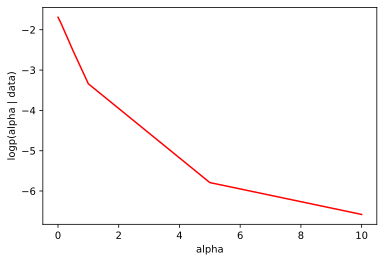

In [24]:
plt.plot(possible_alphas, alpha_logposterior([[0,0,0,0,0,0],[1,1,1,1,1,1]],alpha_calculate_logprior()),'red')
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")

*OK, it's not a very exciting plot (I made the line red just to jazz it up a bit), but I can see that the posterior based on this data (with 2 very regular speakers) has higher probability for low values of `alph`a, and lower probability for high values of `alpha` - that makes sense given that I know that low `alpha` is an expectation of regularity, so my model can learn that if it encounters two regular speakers it should develop an expectation for regularity.*

- Try plugging in different kinds of data (e.g. data from three individuaully-variable speakers) to see how that affects the posterior distribution over alpha values. How does the model match up to your intuitions about what we can learn from exposure to individually-variable or individually-consistent speakers?

Text(0, 0.5, 'logp(alpha | data)')

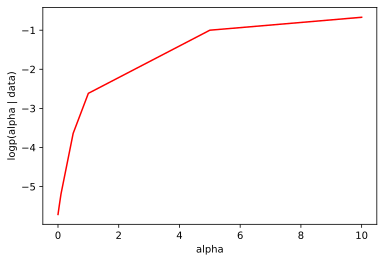

In [25]:
plt.plot(possible_alphas, alpha_logposterior([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]],alpha_calculate_logprior()),'red')
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")

*So that goes in the opposite direction, with higher posterior probability on higher values of alpha - that fits my intuition that, when exposed to several highly variable speakers, you should infer that speakers tend to be highly variable, which is captured with a high `alpha`.*

Finally, we might also want to have our model predict, based on what it's learned from some data, what *new* data sources (i.e. new speakers) would look like. `alpha_logproduce` will do this for you - you pass it a posterior produced by `alpha_logposterior`, tell it how many sources you want it to generate data for (`n_sources`) and how many data points you want per source (`n_productions_per_source`) and it'll generate some random data for you. 

In [26]:
def alpha_logproduce(alpha_logposterior, n_sources, n_productions_per_source):
    alpha_i_index = log_roulette_wheel(alpha_logposterior) #select a value of alpha based on alpha_logposterior
    alpha = possible_alphas[alpha_i_index]
    #print(alpha) #uncomment this if you want to see the alpha value it has selected from the posterior
    pW1_logprior = pW1_calculate_logprior(alpha) #prior over pW1 given this value of alpha
    produced_data = []
    for i in range(n_sources): #for each source
        pW1_i_index = log_roulette_wheel(pW1_logprior) #select a random pW1 for this source based on the prior
        pW1_i = possible_logpW1[pW1_i_index] 
        data_i = pW1_logproduce(pW1_i, n_productions_per_source) #generate some data using this pW1
        produced_data.append(data_i) #and add it to our building data
    return produced_data

For example, you can use this code as follows to calculate a posterior based on data from two speakers and then use it to predict the data that would be generated by two new speakers each producing 10 data items:
```python
a_posterior = alpha_logposterior([[0,0,0,0,0,0],[1,1,1,1,1,1]],alpha_calculate_logprior())
alpha_logproduce(a_posterior, 2, 10)
```

Again, have a little play around with this to see how the data affects the inferred posterior and how that in turn affects the new data generated by `alpha_logproduce`.

*I'll just do production for the posteriors I plotted above.*

In [43]:
posterior_from_regular = alpha_logposterior([[0,0,0,0,0,0],[1,1,1,1,1,1]],alpha_calculate_logprior())
alpha_logproduce(posterior_from_regular, 2, 10)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [39]:
posterior_from_variable = alpha_logposterior([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]],alpha_calculate_logprior())
alpha_logproduce(posterior_from_variable, 2, 10)

[[1, 1, 1, 0, 1, 1, 0, 1, 0, 0], [1, 1, 1, 0, 1, 1, 1, 0, 0, 1]]

*Those look roughly as expected - when producing from `posterior_from_regular` you tend to get regular data (each speaker produces mainly 0s or mainly 1s), when producing from `posterior_from_variable` you tend to get speakers who produce quite variable data. Note that there's a random element to this though - it's possible (but unlikely) to sample high `alpha` from `posterior_from_regular`, or low `alpha` from `posterior_from_variable`.*

## Questions

The priority for this worksheet is to work through the in-text questions above, experimenting with the code and checking in particular that the `alpha_likelihood`, `alpha_logposterior` and `alpha_logproduce` functions make sense to you. Once you are happy with that, try these questions:

1. Imagine you have data from two speakers each producing 6 data items. How does the data generated by those speakers affect the learner's posterior probability distribution over values of `alpha`? You could see what happens when learning from highly regular speakers who both use the same variant, highly regular speakers who use *different* variants, two highly variable speakers, or two speakers who differ in their variability. How does the behaviour of the model match (or not!) your intuitions about how a learner should respond to this kind of data?

*First thing to show is that higher regularity favours lower vaues of `alpha`. I could do this just by printing the values returned by `alpha_logposterior` but I will plot them instead.*

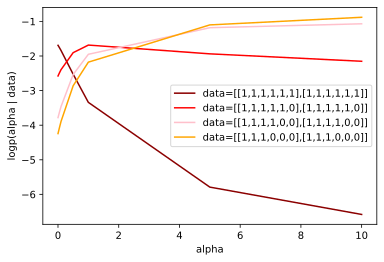

In [29]:
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[1,1,1,1,1,1]],alpha_calculate_logprior()),'darkred',label="data=[[1,1,1,1,1,1],[1,1,1,1,1,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,0],[1,1,1,1,1,0]],alpha_calculate_logprior()),'red',label="data=[[1,1,1,1,1,0],[1,1,1,1,1,0]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,0,0],[1,1,1,1,0,0]],alpha_calculate_logprior()),'pink',label="data=[[1,1,1,1,0,0],[1,1,1,1,0,0]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,0,0,0],[1,1,1,0,0,0]],alpha_calculate_logprior()),'orange',label="data=[[1,1,1,0,0,0],[1,1,1,0,0,0]]")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend()

*That looks roughly as I expected, but one thing that's quite striking is that any within-speaker variability makes the very low values of `alpha` have low posterior probability (compare the dark red vs red lines).*

*Next thing to check is what this looks like if the two speakers use **different** variants - based on the comments above I expect this not to matter, since all this model cares about is per-speaker variability/regularity rather than which variant each speaker uses, but I can plot it and check.*

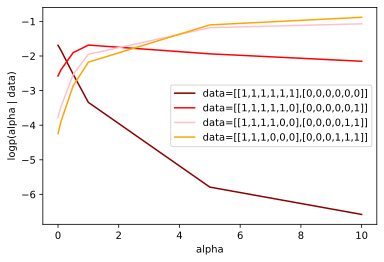

In [30]:
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,0,0,0]],alpha_calculate_logprior()),'darkred',label="data=[[1,1,1,1,1,1],[0,0,0,0,0,0]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,0],[0,0,0,0,0,1]],alpha_calculate_logprior()),'red',label="data=[[1,1,1,1,1,0],[0,0,0,0,0,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,0,0],[0,0,0,0,1,1]],alpha_calculate_logprior()),'pink',label="data=[[1,1,1,1,0,0],[0,0,0,0,1,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,0,0,0],[0,0,0,1,1,1]],alpha_calculate_logprior()),'orange',label="data=[[1,1,1,0,0,0],[0,0,0,1,1,1]]")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend()

*Yup, it looks exactly the same. So far this is in line with the intuitions I outlined above, although it is a bit unexpected how even a tiny bit of variability (1 in 6) flips the alpha.*

*Final thing I want to do is look at what happens when you learn from 1 highly regular speaker and 1 variable speaker, looking at different degrees of variability. I don't have strong intuitions here - I guess if your input is heterogeneous in this sense (some speakers are highly regular, some highly variable) then you want a very flat prior over `pW1` for each speaker, which means `alpha` around 1? Not sure though, maybe you'd end up with a very flat posterior distribution over `alpha`, reflecting the fact that there's a great deal of uncertainty.*

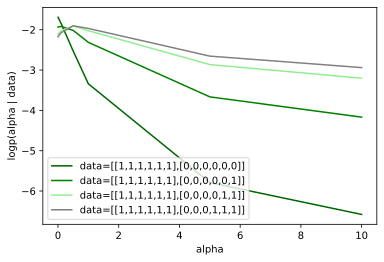

In [31]:
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,0,0,0]],alpha_calculate_logprior()),'darkgreen',label="data=[[1,1,1,1,1,1],[0,0,0,0,0,0]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,0,0,1]],alpha_calculate_logprior()),'green',label="data=[[1,1,1,1,1,1],[0,0,0,0,0,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,0,1,1]],alpha_calculate_logprior()),'lightgreen',label="data=[[1,1,1,1,1,1],[0,0,0,0,1,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,1,1,1]],alpha_calculate_logprior()),'grey',label="data=[[1,1,1,1,1,1],[0,0,0,1,1,1]]")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend()

*So that looks like a bit of both - you can see from e.g. data=[[1,1,1,1,1,1],[0,0,0,1,1,1]] that there's a little peak around `alpha`=1, but it's not very pronounced, and the distribution is generally fairly flat. If you are interested you could see what happens with the same sort of data sampled from more speakers (e.g. 2 highly regular and 2 variable).*

2. How do those results change if you have more data from each speaker, e.g. 12 data points per speaker rather than 6?

*This is quite easy to look at just by copying the code above. It gets a bit laborious to type out all the 0s and 1s so I am going to use the shortcut for repeating lists we saw in previous lab answer sheets. I want to plot the same plot as before plus the new doubled-data lines, so I am going to use a mix of colour and dashes so i can see which lines have the same regularity of data but just more of it.*

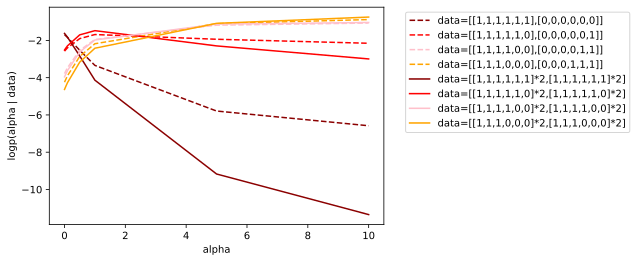

In [32]:
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1],[0,0,0,0,0,0]],alpha_calculate_logprior()),'darkred',linestyle='dashed',label="data=[[1,1,1,1,1,1],[0,0,0,0,0,0]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,0],[0,0,0,0,0,1]],alpha_calculate_logprior()),'red',linestyle='dashed',label="data=[[1,1,1,1,1,0],[0,0,0,0,0,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,0,0],[0,0,0,0,1,1]],alpha_calculate_logprior()),'pink',linestyle='dashed',label="data=[[1,1,1,1,0,0],[0,0,0,0,1,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,0,0,0],[0,0,0,1,1,1]],alpha_calculate_logprior()),'orange',linestyle='dashed',label="data=[[1,1,1,0,0,0],[0,0,0,1,1,1]]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,1]*2,[1,1,1,1,1,1]*2],alpha_calculate_logprior()),'darkred',label="data=[[1,1,1,1,1,1]*2,[1,1,1,1,1,1]*2]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,1,0]*2,[1,1,1,1,1,0]*2],alpha_calculate_logprior()),'red',label="data=[[1,1,1,1,1,0]*2,[1,1,1,1,1,0]*2]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,1,0,0]*2,[1,1,1,1,0,0]*2],alpha_calculate_logprior()),'pink',label="data=[[1,1,1,1,0,0]*2,[1,1,1,1,0,0]*2]")
plt.plot(possible_alphas, alpha_logposterior([[1,1,1,0,0,0]*2,[1,1,1,0,0,0]*2],alpha_calculate_logprior()),'orange',label="data=[[1,1,1,0,0,0]*2,[1,1,1,0,0,0]*2]")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend(bbox_to_anchor=(1.05, 1)) #this puts the legend outside the plot area

*Looks like adding more data just makes the model more confident about its predictions (all the distributions are slightly more exagerated), particularly when the speakers are highly regular (dark red lines).*

3. How does changing the number of speakers (sources) change the shape of the posterior? For instance, if you have 16 data points split across 1, 2, 4, 8, or 16 speakers, how does it affect the learner's inferred posterior over `alpha`, and why? It might be worth thinking about your intuitions here before you run the model - if you want to infer what speakers are like in general, would you rather have lots of data from very few speakers, very little data from lots of speakers, or something in the middle? Again, see if the model matches your intuitions.

*OK, intuitions first. I think that having data from more speakers should in general mean you are better able to infer how variable speakers are - so if I only see data from one speaker I should have very low confidence in generalising to how **all** speakers behave, whereas if I have data from e.g. 8 speakers I should be more confident in generalising. But if I go too far then I'll have very little data from each speaker, and at some point that will prevent me from inferring anything about individual speakers, which means I can't infer anything about speakers in general. So it feels like there should be a sweet spot.*

*I am going to give the code for looking at this with highly regular speakers first.*

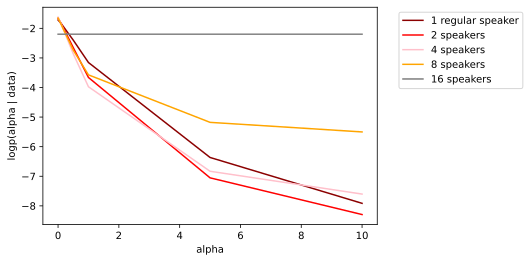

In [33]:
plt.plot(possible_alphas, alpha_logposterior([[1]*16],alpha_calculate_logprior()),'darkred',label="1 regular speaker")
plt.plot(possible_alphas, alpha_logposterior([[1]*8]*2,alpha_calculate_logprior()),'red',label="2 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*4]*4,alpha_calculate_logprior()),'pink',label="4 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*2]*8,alpha_calculate_logprior()),'orange',label="8 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*1]*16,alpha_calculate_logprior()),'grey',label="16 speakers")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend(bbox_to_anchor=(1.05, 1)) #this puts the legend outside the plot area

*OK, so first thing to note is that having 16 data points spread over 16 speakers (1 data point per speaker) means that the model can't infer anything - its posterior is completely flat, because it can;t estimate how variable each speaker is from a single datapoint so is totally clueless.*

*Of the others, the difference seems quite subtle but it looks like the red line (adequate data from 2 speakers) is the most confident that `alpha` should not be high; getting data from only 1 speaker makes the prior a bit flatter. So this doesn;t really match my intuitions very well, possible because when I go to e.g. 4 speakers I am getting too little data from each. Let's try with 32 datapoints total.*

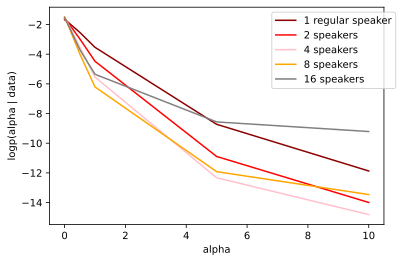

In [34]:
plt.plot(possible_alphas, alpha_logposterior([[1]*32],alpha_calculate_logprior()),'darkred',label="1 regular speaker")
plt.plot(possible_alphas, alpha_logposterior([[1]*16]*2,alpha_calculate_logprior()),'red',label="2 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*8]*4,alpha_calculate_logprior()),'pink',label="4 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*4]*8,alpha_calculate_logprior()),'orange',label="8 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1]*2]*16,alpha_calculate_logprior()),'grey',label="16 speakers")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend(bbox_to_anchor=(1.05, 1)) #this puts the legend outside the plot area

*That looks a bit more like what I was expecting - now the pink line (4 speakers, each with 8 data points) has the lowest posterior on `alpha` being high (i.e. after seeing good data from 4 regular speakers it's quite confident that speakers in general will be regular).* 

*Now I'll take a look at learning from **variable** speakers (dropping back down to 16 datapoints total). Note that I need at least 2 datapoints per speaker here (from 1 data point there's no way to be variable), so the highest I can go is 8 speakers.*

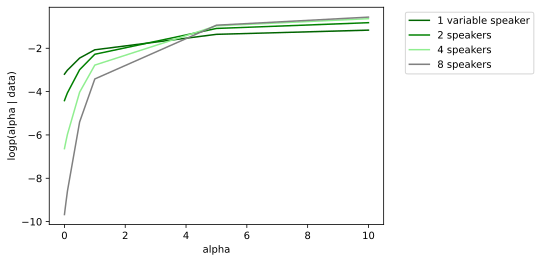

In [35]:
plt.plot(possible_alphas, alpha_logposterior([[1,0]*8],alpha_calculate_logprior()),'darkgreen',label="1 variable speaker")
plt.plot(possible_alphas, alpha_logposterior([[1,0]*4]*2,alpha_calculate_logprior()),'green',label="2 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1,0]*2]*4,alpha_calculate_logprior()),'lightgreen',label="4 speakers")
plt.plot(possible_alphas, alpha_logposterior([[1,0]*1]*8,alpha_calculate_logprior()),'grey',label="8 speakers")
plt.xlabel("alpha")
plt.ylabel("logp(alpha | data)")
plt.legend(bbox_to_anchor=(1.05, 1)) #this puts the legend outside the plot area

*This looks like it's in line with my intuitions - data from more speakers leads to the model being more confident that speakers in general are variable (i.e. that `alpha` should be high). The fact that this seems pretty clear here but was less clear when looking at regular speakers suggests there's a bit of an asymmetry in this model - even with small data it's easy to show that you are variable, whereas small data makes it relatively hard to show you are regular (i.e. if I see data `[0,1]` I am confident you are variable, but if I see `[0,0]` there's a good chance you are actually variable but I just don't have enough data to see it.*  

4. I was slightly cowardly about the prior over values of `alpha` and just used a uniform prior. Do you think you can mount an argument here that this prior should be something other than uniform? If you are feeling ambitious, plug in a different shape over prior (by creating a new version of `alpha_calculate_logprior`) and see how it affects the model's behaviour. 

*I can imagine that maybe there's a general expectation of regularity (i.e. a prior favouring low alpha), although you might have a different intuition! If I wanted to add this I would need to define a new prior, and since a prior  is just a list of log probabilities, I can basically specify any shape I want. Say for example I wanted to boost the prior on all the `alphas` under 1 (the first 6 values in `possible_alphas`) a bit, I could do something like this:*

In [36]:
def alpha_calculate_logprior_new():
    unnormalised_logprior = [log(2/15)]*6 + [log(1/15)]*3
    return normalize_logprobs(unnormalised_logprior) 

In [37]:
alpha_calculate_logprior_new()

[-2.0149030205422647,
 -2.0149030205422647,
 -2.0149030205422647,
 -2.0149030205422647,
 -2.0149030205422647,
 -2.0149030205422647,
 -2.70805020110221,
 -2.70805020110221,
 -2.70805020110221]

In [38]:
print(exp(alpha_calculate_logprior_new()[0]))
print(exp(alpha_calculate_logprior_new()[8]))

0.13333333333333333
0.06666666666666667


*That looks a bit arbitrary, but it shows you how you could change the shape of the prior.*

5. [Potentially a relatively challenging coding problem] How would you turn this into an iterated learning model, where learners sample data from multiple speakers in a population, infer how variable they should be on the basis of that data, and then produce more data for the next generation? What kinds of design decisions would you have to make in setting up this model? What kind of data would you want to track over generations? It's OK just to think about this, but if you are feeling ambitious and have time on your hands you can adapt the `iterate`function from lab 4 to build this hierarchical iterated learning model.

*I'm not going to build this model since we are going to look at populations in the next couple of labs anyway. But it's a useful to think about the kinds of design decisions you'd have to make to set up this model. The first big difference from the iterated learning model we looked at in lab 4 is that you are probably going to want to move from a model where there is one agent per generation to multiple - otherwise there's not too much point in using this hierarchical model. Then you'd have to decide how many speakers at the previous generation your learner would sample data from - this could be a parameter, along with the total amount of data learners get. You'd also have to decide **who** to sample from - do you just want to select some random input sources for each learner, or somehow impose some social structure on the population? That sounds potentially a bit complicated, so might be better to sample randomly. You'll also have to decide how to turn from being a learner to a producer - what's the logical way to use the `alpha_logproduce` function to model productions by a single speaker? And what are you going to record at each generation - the distribution over `alpha` values each individual infers, or just the `alpha` value they use when they come to produce, or do you also want to track the actual data (sequences of 1s and 0s) that get transmitted from generation to generation? Finally, it's worth thinking about what you expect to happen here - do you have any expectations about what will come out of this iterated learning model, where we essentially transmit an `alpha` value from generation to generation, based on what we have seen about iterated learning so far?*